In [1]:
import numpy as np
data = np.load('dataset.npy')

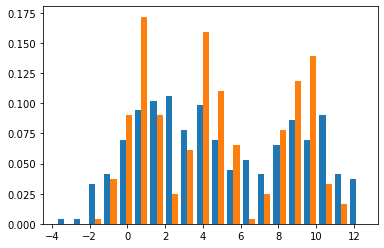

In [2]:
#Let how our data does look like. 
#Therefore, we can interpret 3 Gaussians of the data set. 
from matplotlib import pyplot
pyplot.hist(data, bins = 20, density = True)
pyplot.show()

In [3]:
def initial_values(data, k):
    #choose an initial sigma value for a point in data.
    #it will be 2x2 in our case.
    sigma = 0.000003 * np.identity(len(data[0]))
    x, y = np.meshgrid(np.sort(data[:,0]),np.sort(data[:,1]))
    
    
    #we can choose random k points in data as means 
    #k will be 3 and mu will be 3x2 for our case.
    random_indices = np.random.choice(data.shape[0], 3)
    mu = data[random_indices, :]
    
    #also define initial k covariance matrices;
    #that is; we have 3 2x2 covariance matrices for initial values.
    #we can choose any arbitrary matrix for this purpose.
    cov_matrices = np.zeros((k,len(data[0]),len(data[0])))
    for dim in range(len(cov_matrices)):
            np.fill_diagonal(cov_matrices[dim],2)
        
    #and finally, we have to define initial π_k's. 
    #for our case, we need to 3 π_k values and we can choose as they are equal.
    pi = np.ones(k)/k
    
    return sigma, x, y, mu, cov_matrices, pi
    

In [4]:
def multivariate_normal_pdf(x, mu, sigma):
    #Initialize and reshape
    x = x.reshape(-1,1)
    mu = mu.reshape(-1,1)
    d,_ = sigma.shape
    x_m = x - mu

    #Compute values 
    a = np.sqrt((2 * np.pi)**d * np.linalg.det(sigma))
    b = -(1/2) * (x_m.T @ np.linalg.inv(sigma) @ x_m)
    
    return (1 / a) * np.exp(b)



In [5]:
sigma, x, y, mu, cov_matrices, pi = initial_values(data, 3)

In [6]:
log_likelihood = []
for i in range(3):
    log_likelihood.append(np.log(np.sum([k * np.array([multivariate_normal_pdf(np.array([a,b]).reshape(-1,1), mu[i], cov_matrices[j])
                                                 for a, b in zip(np.ravel(data[:,0]), np.ravel(data[:,1]))])
                                          for k, i, j in zip(pi ,range(len(mu)),range(len(cov_matrices)))])))



print(log_likelihood)

[1.2383642202384506, 1.2383642202384506, 1.2383642202384506]


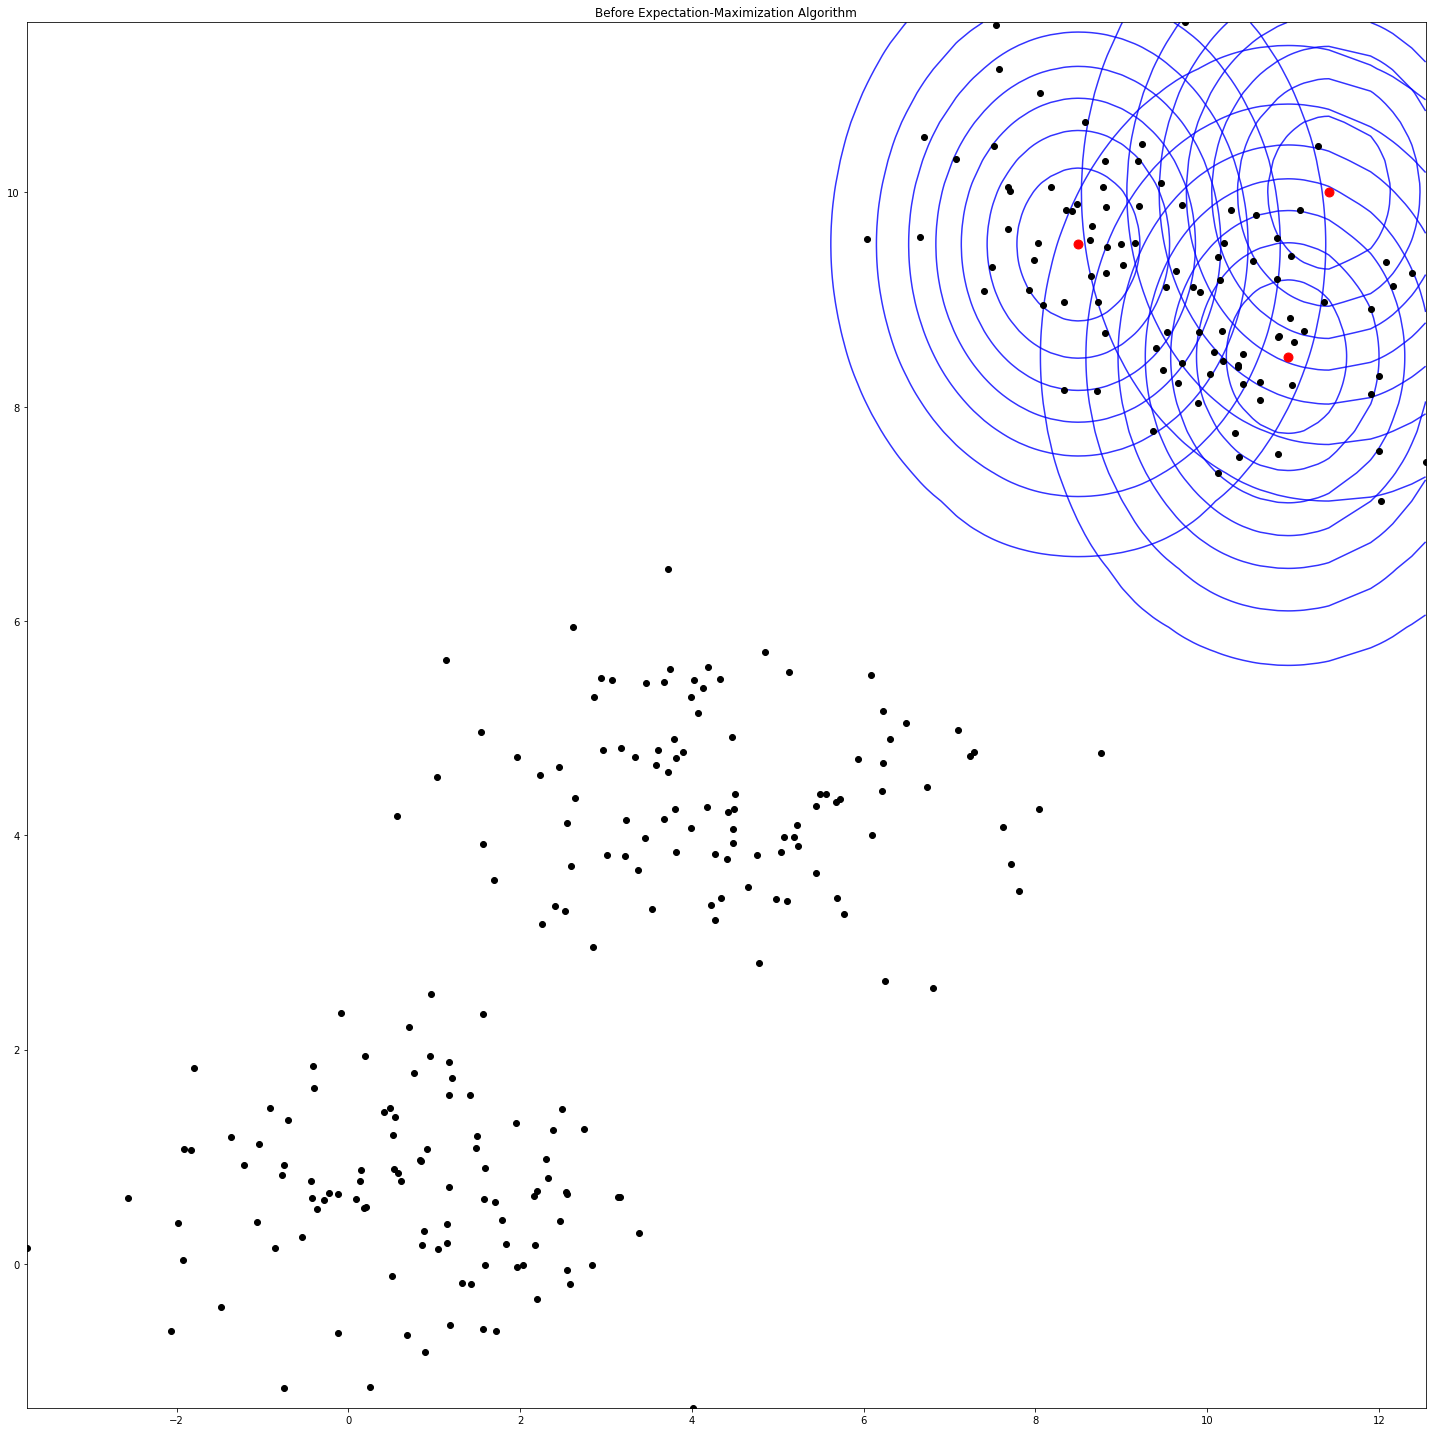

In [7]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(20,20))
plt.plot(data[:, 0], data[:, 1], 'ko')
for m,c in zip(mu,cov_matrices):
    c += sigma
    plt.contour(np.sort(data[:,0]),
                np.sort(data[:,1]),np.array([multivariate_normal_pdf(np.array([xx,yy]).reshape(-1,1), m, c)
                                             for xx, yy in zip(np.ravel(x), np.ravel(y))]).reshape(len(data),len(data)),
                colors='blue',alpha=0.8)
    plt.scatter(m[0],m[1], c='red', zorder=20, s=80)
    
plt.title('Before Expectation-Maximization Algorithm')
plt.tight_layout()

In [8]:
def expectation_maximization(data, k, iterations):
    
    sigma, x, y, mu, cov_matrices, pi = initial_values(data, k)
    
    for i in range(iterations):
        ##Expectation
        gamma = np.zeros((len(data),len(cov_matrices)))

        for m, cov, p, g in zip(mu, cov_matrices, pi, range(len(gamma[0]))):
            cov += sigma
            multivariate_normal_1 = np.array([multivariate_normal_pdf(np.array([a,b]).reshape(-1,1), m, cov)
                                                 for a, b in zip(np.ravel(data[:,0]), np.ravel(data[:,1]))])
        
            summation = np.sum([pi_ * np.array([multivariate_normal_pdf(np.array([xx,yy]).reshape(-1,1), mu_, cov_) 
                                                 for xx, yy in zip(np.ravel(data[:,0]), np.ravel(data[:,1]))]) 
                                for pi_ ,mu_, cov_ in zip(pi, mu, cov_matrices + sigma)], axis=0)
            
            
            gamma[:, g] = (p * multivariate_normal_1 / summation).reshape(len(data), )
    
        ##Maximixation
        mu_new = []
        cov_matrices_new = []
        pi_new = []
        log_likelihood_new = []
    
        for i in range(len(gamma[0])):
                    m1 = np.sum(gamma[:,i], axis=0)
                    m2 = (1 / m1) * np.sum(data * gamma[:,i].reshape(len(data),1), axis=0)
                    
                    mu_new.append(m2)
                    cov_matrices_new.append(((1/ m1) * np.dot((np.array(gamma[:,i]).reshape(len(data), 1) * (data - m2)).T,(data - m2))) + sigma)          
                    pi_new.append(m1 / np.sum(gamma)) 
                    log_likelihood_new.append(np.log(np.sum([d * np.array([multivariate_normal_pdf(np.array([a,b]).reshape(-1,1), mu_new[e], cov_matrices_new[f])
                                                 for a, b in zip(np.ravel(data[:,0]), np.ravel(data[:,1]))])
                                          for d, e, f in zip(pi_new ,range(len(mu_new)),range(len(cov_matrices_new)))])))


    
    
    mu_new = np.array(mu_new)
    cov_matrices_new = np.array(cov_matrices_new)
    pi_new = np.array(pi_new)
    log_likelihood_new = np.array(log_likelihood_new)
    
    
    return gamma, mu_new, cov_matrices_new, pi_new, log_likelihood_new
                

In [9]:
gamma, mu_new, cov_matrices_new, pi_new, log_likelihood_new = expectation_maximization(data, 3, 400)

In [10]:
print(log_likelihood_new)

[0.57146125 1.32132665 1.80122204]


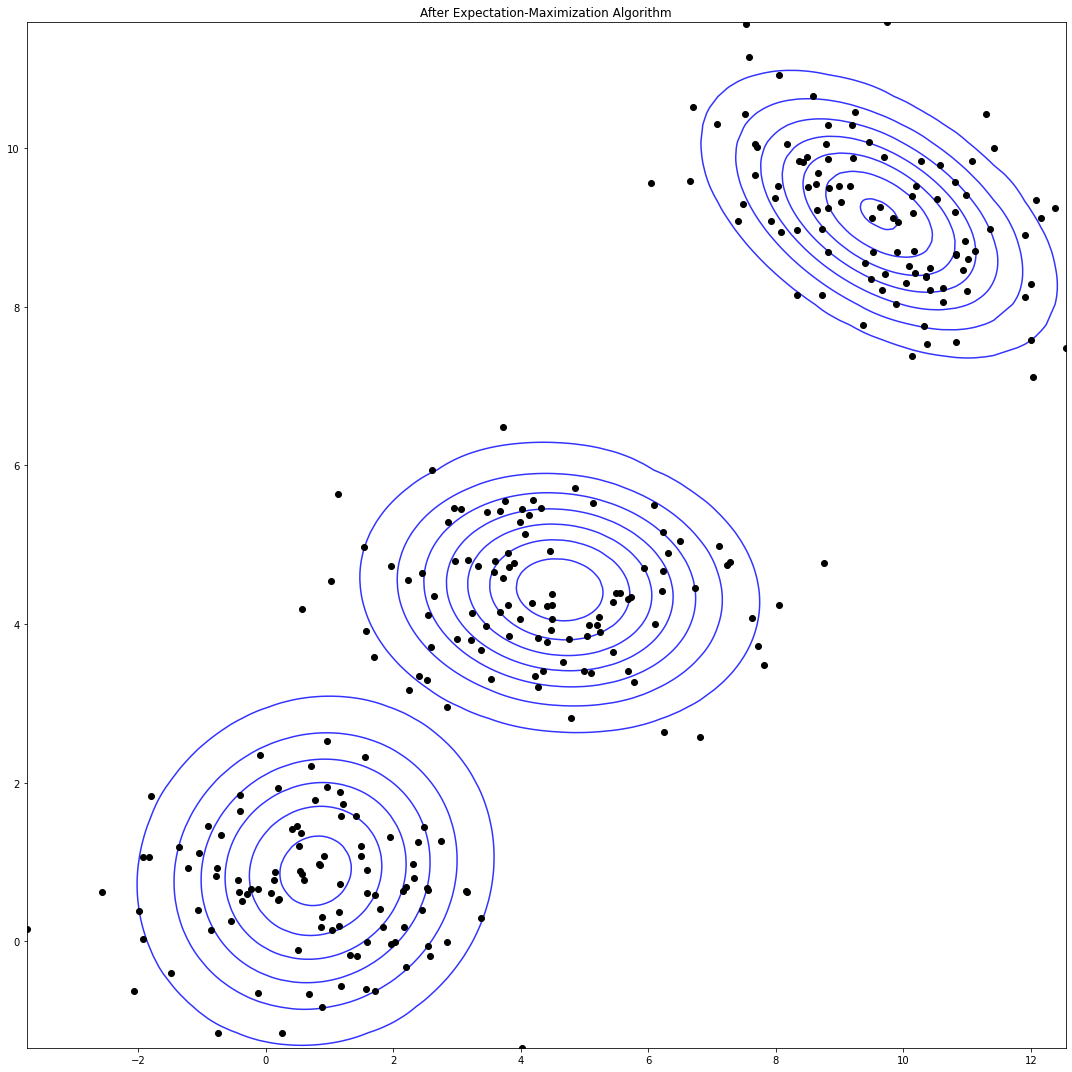

In [11]:
plt.figure(figsize=(15,15))
plt.plot(data[:, 0], data[:, 1], 'ko')
for m_new,c_new in zip(mu_new, cov_matrices_new):
    plt.contour(np.sort(data[:,0]),
                np.sort(data[:,1]),np.array([multivariate_normal_pdf(np.array([xx,yy]).reshape(-1,1), m_new, c_new)
                                             for xx, yy in zip(np.ravel(x), np.ravel(y))]).reshape(len(data),len(data)),
                colors='blue',alpha=0.8)

    
plt.title('After Expectation-Maximization Algorithm')
plt.tight_layout()
